<a href="https://colab.research.google.com/github/harshnandwana/Depression-prediction-/blob/main/Suicide%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
import re
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv('/content/drive/MyDrive/sentiment_tweets3.csv')
df.head()

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [4]:
df = df.rename(columns=({'message to examine':'tweet'}))
df = df.rename(columns=({'label (depression result)':'lab'}))
df.columns

Index(['Index', 'tweet', 'lab'], dtype='object')

In [5]:
df.shape
df['lab'].value_counts()

0    8000
1    2314
Name: lab, dtype: int64

looks like data is imbalanced and sorted 

###Text Preprocessing

In [6]:
def cleanhtml(phrase):
    text=re.compile('<.*?>')
    phrase=re.sub(text,' ',phrase)
    return phrase

def decont(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"PRON", " ", phrase)
    phrase = re.sub(r"pron", " ", phrase)
    #remove any url
    phrase = re.sub(r"http[s]?://\S+"," ", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    #special char
    phrase = re.sub(r'[^A-Za-z0-9]+', " ", phrase)

    phrase = re.sub(r"@+"," ", phrase)

    #remove any thing with html tags
    phrase = cleanhtml(phrase)
    return phrase


In [7]:
import nltk
from nltk.corpus import stopwords 
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import string 
nltk.download('stopwords')
nltk.download('punkt')
import spacy
nlp = spacy.load('en_core_web_sm')
lmtzr = WordNetLemmatizer()
import re
sno= nltk.stem.SnowballStemmer('english')
def text_preprocess(text):
    lm = []
    text = nlp(text)
    for token in text:
        k=(token.lemma_)
        k=decont(k)
        #k=sno.stem(k)
        lm.append(k)
    text = " ".join(lm)
    text = text.translate(str.maketrans("", "", string.punctuation))
    #text = [word for word in text.split() ]#if word.lower() not in stopwords.words('english')]
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    #print(text)
    return " ".join(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
df['ptt'] = df['tweet'].apply(text_preprocess)

In [9]:
df.head()

,Index,tweet,lab,ptt
0,106,just had a real good moment. i missssssssss hi...,0,real good moment missssssssss much
1,217,is reading manga http://plurk.com/p/mzp1e,0,read manga
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0,comeagainjen
3,288,@lapcat Need to send 'em to my accountant tomo...,0,lapcat need send accountant tomorrow oddly eve...
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,add MYSPACE myspace com lookthunder


In [10]:
df.to_csv("tweetp",index=False)

###Convert word to vec

In [11]:
from gensim.models import word2vec
from gensim.models import keyedvectors
import gensim
#keyedvectors.load_word2vec_format

In [12]:
i=0
list_of_sentance=[]
for sentance in df['ptt']:
    list_of_sentance.append(sentance.split())

In [13]:
list_of_sentance[2]

['comeagainjen']

In [14]:

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=gensim.models.Word2Vec(list_of_sentance,min_count=2,size=50, workers=4)
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [15]:
print(w2v_model.wv.most_similar('depression'))

[('stress', 0.999860942363739), ('Depression', 0.9998353719711304), ('disorder', 0.999812126159668), ('deal', 0.9998104572296143), ('health', 0.9998101592063904), ('anxiety', 0.9998062252998352), ('find', 0.999799907207489), ('check', 0.9997876286506653), ('suffer', 0.9997865557670593), ('cure', 0.999783456325531)]


In [16]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 2 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 2 times  5912
sample words  ['real', 'good', 'moment', 'much', 'read', 'comeagainjen', 'need', 'send', 'tomorrow', 'even', 'refer', 'support', 'evidence', 'though', 'add', 'myspace', 'com', 'sleepy', 'time', 'tonight', 'someone', 'already', 'say', 'home', 'mean', 'least', 'regular', '23', '24', 'c', 'possible', 'today', 'Nice', 'nite', 'twitterville', 'workout', 'Night', 'Sweet', 'dream', 'morning', 'everybody', 'finally', 'create', 'Blog', 'blog', 'Seattle', 'cnt', 'get', 'u', 'til']


In [17]:
w2v_model['depression']

array([ 0.8853219 ,  0.08318988,  1.0465348 ,  1.3969556 ,  0.85342574,
       -0.25706765,  0.3124922 , -1.5849537 ,  0.44127223,  0.97075444,
        0.821909  , -0.5286058 , -0.84661925, -1.3790228 , -0.8454032 ,
       -0.4324    ,  0.68795615,  1.6262851 ,  1.2400714 , -1.3022972 ,
        0.456775  , -0.8799951 , -1.4541024 , -0.1291715 ,  0.3937129 ,
        0.06004417,  0.4697705 ,  0.09816852,  0.06998866, -2.1096585 ,
       -0.22463544, -0.98701155,  0.54956806, -0.23668934,  1.719024  ,
        0.29371294,  0.6270576 , -0.6358524 , -0.23765884,  1.0059378 ,
        0.662911  , -0.23398504,  1.4903947 , -1.450063  , -0.3629126 ,
        0.95400935, -0.67800003,  0.51403695,  1.032965  ,  0.01962596],
      dtype=float32)

In [18]:
from tqdm import tqdm
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(list_of_sentance): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a review/sentence
        if word in w2v_words:
            vector += w2v_model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))

100%|██████████| 10314/10314 [00:05<00:00, 1832.07it/s]

10314
50


In [19]:
len(avg_w2v_vectors),df['lab'].shape

(10314, (10314,))

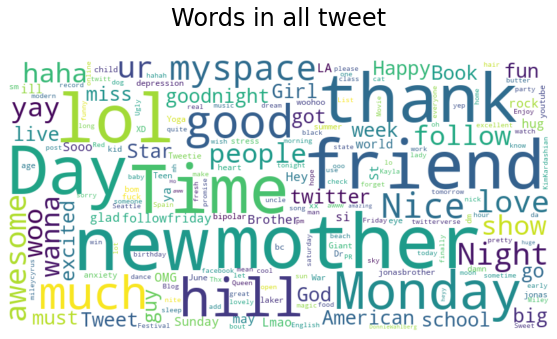

In [20]:
from wordcloud import WordCloud
words = ' '.join([text for text in w2v_words])
wordcloud = WordCloud(
    width=800, height=400, background_color='white', max_font_size=110)\
    .generate(words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Words in all tweet\n', fontsize=24)
plt.axis('off')
plt.show()

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test = train_test_split(avg_w2v_vectors, df['lab'], test_size=0.25)
#X_train, X_cv, y_train,y_cv = train_test_split(X_Train, y_Train, test_size=0.25)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

In [23]:
lr = LogisticRegression()
clf= SGDClassifier()

In [24]:
param={"alpha":np.logspace(-10,10,11), "penalty":["l1","l2"], "loss":["hinge","log"]}
logreg_cv=GridSearchCV(clf,param,cv=5)
logreg_cv.fit(X_train,y_train)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)

tuned hpyerparameters :(best parameters)  {'alpha': 1e-06, 'loss': 'hinge', 'penalty': 'l1'}


In [25]:
param={"C":np.logspace(-10,10,11), "penalty":["l1","l2"]}
logreg_cv=GridSearchCV(lr,param,cv=5)
logreg_cv.fit(X_train,y_train)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)

tuned hpyerparameters :(best parameters)  {'C': 10000.0, 'penalty': 'l2'}


In [26]:
lr=LogisticRegression(C=10000000000,penalty='l2',solver='liblinear')
clf= SGDClassifier(alpha=1e-06,loss='hinge',penalty='l1')

In [27]:
lr.fit(X_train, y_train)
clf.fit(X_train, y_train)

SGDClassifier(alpha=1e-06, penalty='l1')

In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score

def conf_matrix_acc(y_true, y_pred):
    print(f'Confusion matrix\n:{confusion_matrix(y_true, y_pred)}\n')
    print(f'Accuracy score is : {accuracy_score(y_true, y_pred)}')

In [29]:
y_pred_lr = lr.predict(X_test)
y_pred_sgd = clf.predict(X_test)

In [30]:
conf_matrix_acc(y_test,y_pred_lr )
print("="*100)
print("="*100)
conf_matrix_acc(y_test,y_pred_sgd )

Confusion matrix
:[[1952   53]
 [ 115  459]]

Accuracy score is : 0.934858472276076
Confusion matrix
:[[1988   17]
 [ 303  271]]

Accuracy score is : 0.8759208995734781


## word 2 vec is complete and we are having pretty good accuracy and confusion matrix in case of logistic regression thus logistic regression is favourable for this type of problems with only 2 type of class labels 




===============================================================
###if you wish you can give try to 2 other methodolgies

###1.   TFIDF instead of w2v 
###2.   you can train w2v with google news or some other corpus it will also provide you with some better results but condition is there must be no other special word in your corpus so you can definately give it a shot



In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
model = TfidfVectorizer()
vec=model.fit_transform(df['ptt'])


X1_train, X1_test, y1_train,y1_test = train_test_split(vec, df['lab'], test_size=0.25)

In [32]:
from sklearn.naive_bayes import MultinomialNB
lr1 = LogisticRegression()
clf1= SGDClassifier()
nb1=MultinomialNB()

In [33]:
param={"alpha":np.logspace(-10,10,11), "penalty":["l1","l2"], "loss":["hinge","log"]}
logreg_cv=GridSearchCV(clf1,param,cv=5)
logreg_cv.fit(X1_train,y1_train)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("="*100)
param={"C":np.logspace(-10,10,11), "penalty":["l1","l2"]}
logreg_cv=GridSearchCV(lr1,param,cv=5)
logreg_cv.fit(X1_train,y1_train)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("="*100)
param={"alpha":np.logspace(-10,10,11)}
mnb=GridSearchCV(nb1,param,cv=5)
mnb.fit(X1_train,y1_train)
print("tuned hpyerparameters :(best parameters) ",mnb.best_params_)

tuned hpyerparameters :(best parameters)  {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l1'}
tuned hpyerparameters :(best parameters)  {'C': 100.0, 'penalty': 'l2'}
tuned hpyerparameters :(best parameters)  {'alpha': 0.01}


In [34]:
lr1 = LogisticRegression(C= 100.0, penalty= 'l2')
clf1= SGDClassifier(alpha= 0.0001, loss= 'hinge', penalty= 'l1')
nb1=MultinomialNB(alpha= 0.01)

In [35]:
lr1.fit(X1_train,y1_train)
clf1.fit(X1_train,y1_train)
nb1.fit(X1_train,y1_train)

MultinomialNB(alpha=0.01)

In [36]:
y1_pred_lr = lr1.predict(X1_test)
y1_pred_sgd = clf1.predict(X1_test)
y1_pred_nb = nb1.predict(X1_test)

In [37]:
conf_matrix_acc(y1_test,y1_pred_lr )
print("="*100)
print("="*100)
conf_matrix_acc(y1_test,y1_pred_sgd )
print("="*100)
print("="*100)
conf_matrix_acc(y1_test,y1_pred_nb )

Confusion matrix
:[[1981    1]
 [  17  580]]

Accuracy score is : 0.9930205506010081
Confusion matrix
:[[1982    0]
 [   8  589]]

Accuracy score is : 0.9968980224893369
Confusion matrix
:[[1813  169]
 [  50  547]]

Accuracy score is : 0.9150833656455991



##1.   thus in my case tfidf is performing exceptionally better than w2v
this can be due to various reasons
##2.   for now i will be working around TFIDF model

So model that is recomended is sgd classifier with values
#**SGDClassifier(alpha= 0.0001, loss= 'hinge', penalty= 'l1')**

#make any input


In [42]:
a=input("enter tweet/statement")
a=text_preprocess(a)
#print(a)
avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
vector = np.zeros(50) # as word vectors are of zero length
cnt_words =0; # num of words with a valid vector in the sentence/review
for word in a.split(" "): # for each word in a review/sentence
    if word in w2v_words:
        vector += w2v_model[word]
        cnt_words += 1
if cnt_words != 0:
    vector /= cnt_words
avg_w2v.append(vector)

val=lr.predict(avg_w2v)
if val[0]==1:
  print("not depressed")
else:
  print("depressed")

enter tweet/statementIm not feeling good
depressed
